In [1]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.flipud(np.transpose(img0)))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.flipud(np.transpose(img1)))
    sub1.set_title(title1)


In [2]:
def convolve2d_cutoff(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC)
                    yInd = (y + j - YC)
                    if xInd >= 0 and xInd < dirty_map.shape[0] and yInd >= 0 and yInd < dirty_map.shape[1]:
                        s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

def convolve2d_circular(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC) % psf_map.shape[0]
                    yInd = (y + j - YC) % psf_map.shape[1]
                    s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

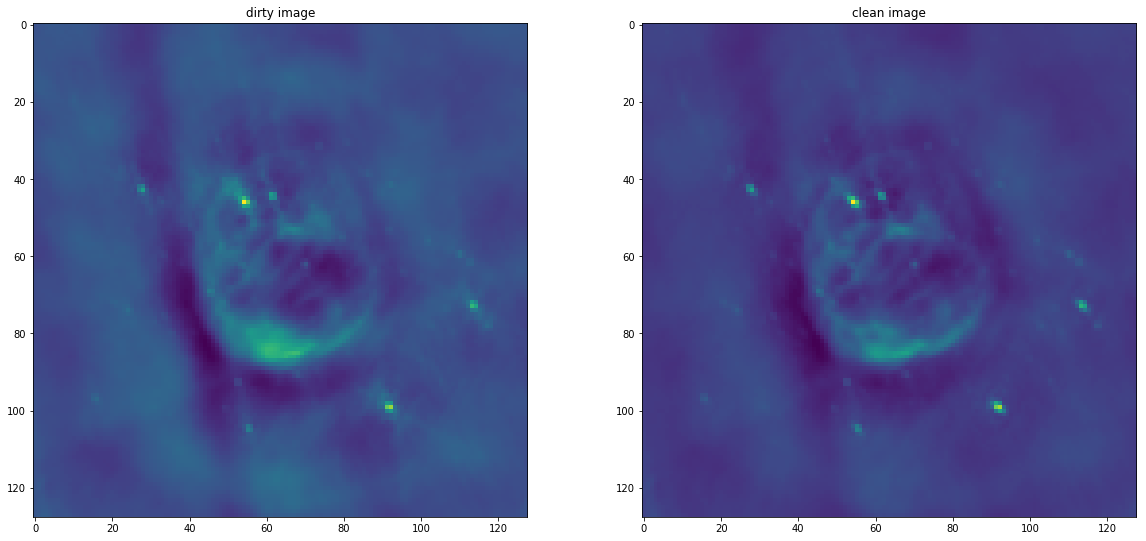

In [3]:
#folder = "./img-csv/test_64.64/"
#folder = "./img-csv/sun.flare00_64.64/"
#folder = "./img-csv/sun.center00_128.128/"
folder = "./img-csv/nova00_128.128/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')
model_map = np.genfromtxt(folder+'model.csv', delimiter=',')

plot_comparison(dirty_map, 'dirty image', clean_map, 'clean image')

In [88]:
np.max(model_map)

0.0056573497131466866

***

## Dirty Map Reconstruction with gurobi

$minimize \left \| D_b - x \right \|_2^2$

In [540]:
dirty_flat = dirty_map.flatten()
m = Model("dirty-reconstruction")

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar(lb=-GRB.INFINITY))
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += (x0[i] - dirty_flat[i])*(x0[i] - dirty_flat[i])

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in m.getVars()], dirty_map.shape)
del m
del obj

Optimize a model with 0 rows, 4096 columns and 0 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e-03, 6e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 4096 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.04 seconds
Optimal objective 1.33383082e-09


In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "reconstruction")

***
## Reconstruction with PSF in Fourier Space ~ CLEAN

$minimize \left \| fft(D_b) - fft(x) * fft(PSF) \right \|_2^2$

In [54]:
D_FT = fourier.fftshift(fourier.fft2(dirty_map))
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

#cut most of the psf
#psf = np.zeros(psf_map.shape)
#cut = int(psf_map.shape[0]/4)
#psf[cut:3*cut, cut:3*cut] = psf_map[cut:3*cut, cut:3*cut]

PSF_FT = fourier.fftshift(fourier.fft2(psf_map))
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

In [61]:
model = Model("dirty-psf")

x0_real = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
x0_imag = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        objective += (D_real[i, j]- (x0_real[i, j] * PSF_real[i, j] - x0_imag[i, j] * PSF_imag[i, j])) * (D_real[i, j]- (x0_real[i, j] * PSF_real[i, j] - x0_imag[i, j] * PSF_imag[i, j]))
        objective += (D_imag[i, j] - (x0_real[i, j] * PSF_imag[i, j] + x0_imag[i,j] * PSF_real[i,j])) * (D_imag[i, j] - (x0_real[i, j] * PSF_imag[i, j] + x0_imag[i,j] * PSF_real[i,j]))
        #objective += (x0_real[i, j] * PSF_real[i, j] - D_real[i, j]) * (x0_real[i, j] * PSF_real[i, j] - D_real[i, j]) #real part
        #objective += (x0_imag[i, j] * PSF_imag[i, j] -D_imag[i, j]) * (x0_imag[i, j] * PSF_imag[i, j] - D_imag[i, j]) #imaginary part

model.setObjective(objective, GRB.MINIMIZE)
model.optimize() 

FT_rec = np.zeros(dirty_map.shape, dtype=np.complex128)
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        FT_rec[i, j] = x0_real[i, j].x + x0_imag[i, j].x * 1j


reconstruction = fourier.ifft2(fourier.ifftshift(FT_rec)).real
m, n = reconstruction.shape
reconstruction = np.roll(reconstruction, int(-m/2),axis=0)
reconstruction = np.roll(reconstruction, int(-n/2),axis=1)
del model
del objective

Optimize a model with 0 rows, 8192 columns and 0 nonzeros
Model has 8192 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e-05, 7e+05]
  QObjective range [1e-04, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 8192 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.04 seconds
Optimal objective 6.75611264e-07


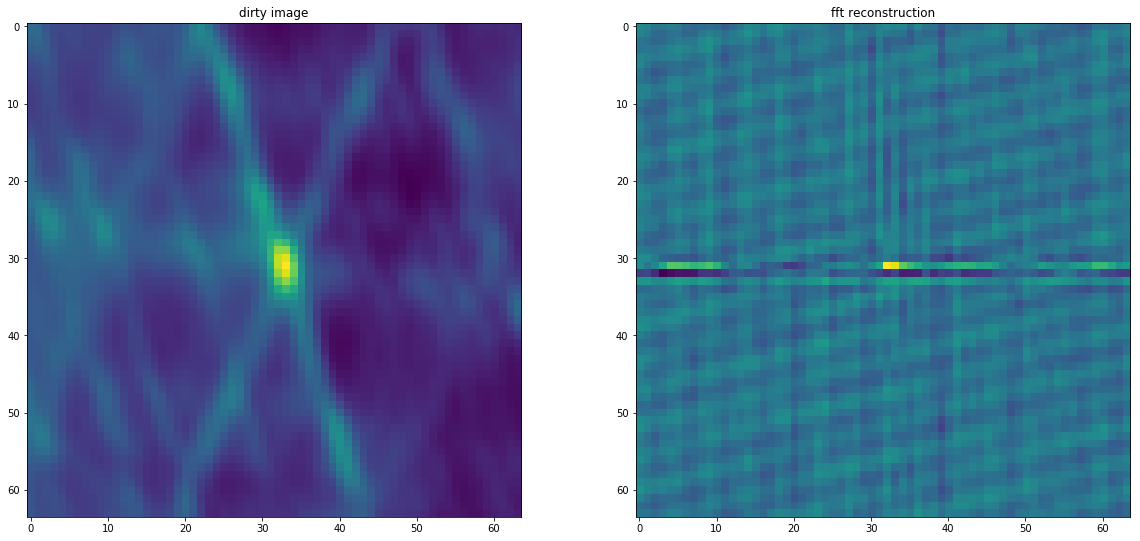

In [62]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "fft reconstruction")

In [63]:
convolve = convolve2d_circular(reconstruction, psf_map)

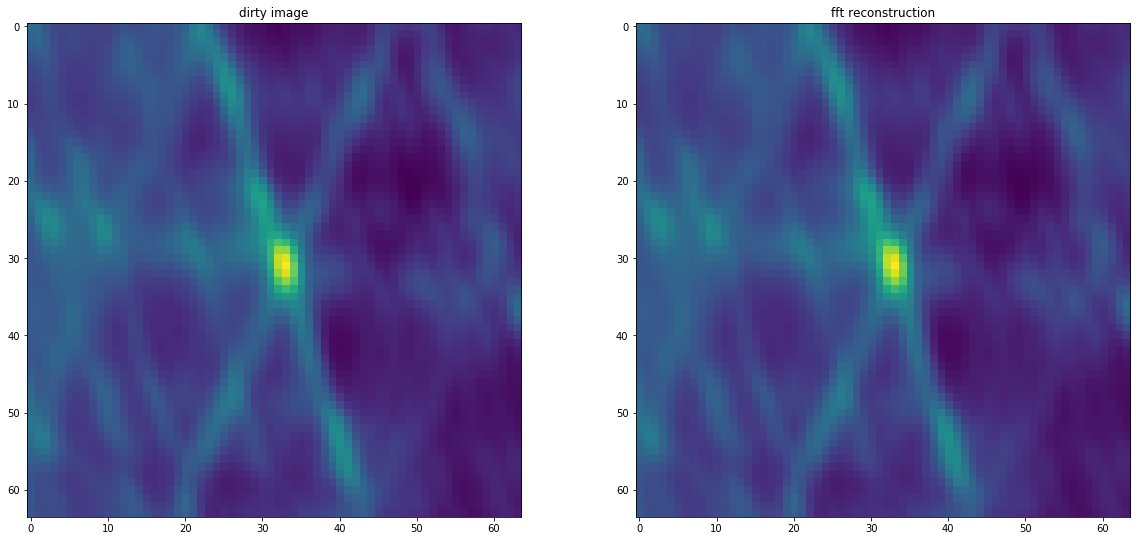

In [64]:
plot_comparison(dirty_map, 'dirty image', convolve, "fft reconstruction")

## Reconstruction with PSF in image space ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [4]:
model = Model("dirty-second try")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)        
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        row.append(model.addVar())
    pixelArr.append(row)

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print(elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  3.277587890625 %
1.0
287.27765941619873


In [5]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_dirty01 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_dirty01[x,y]= pixelArr[x][y].x

Optimize a model with 16384 rows, 32768 columns and 7607558 nonzeros
Model has 16384 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-08, 8e-03]
Presolve time: 4.64s
Presolved: 16384 rows, 32768 columns, 7607558 nonzeros
Presolved model has 16384 quadratic objective terms

       0    6.2015600e-03   0.000000e+00   6.099381e+01      7s
     409    1.6066092e-03   0.000000e+00   1.007734e+01     10s
     749    1.3899024e-03   0.000000e+00   4.464261e+00     19s
    1084    1.3090705e-03   0.000000e+00   2.351433e+00     31s
    1416    1.2708108e-03   0.000000e+00   1.337558e+00     44s
    1746    1.2503317e-03   0.000000e+00   8.153675e-01     56s
    2074    1.2397285e-03   0.000000e+00   5.103162e-01     71s
    2400    1.2329366e-03   0.000000e+00   3.395724e-01     91s
    2723    1.2287857e-03   0.000000e+00   2.345172e-0

In [6]:
np.savetxt("./output-csv/positve_clean.csv",results_dirty01, delimiter=',')

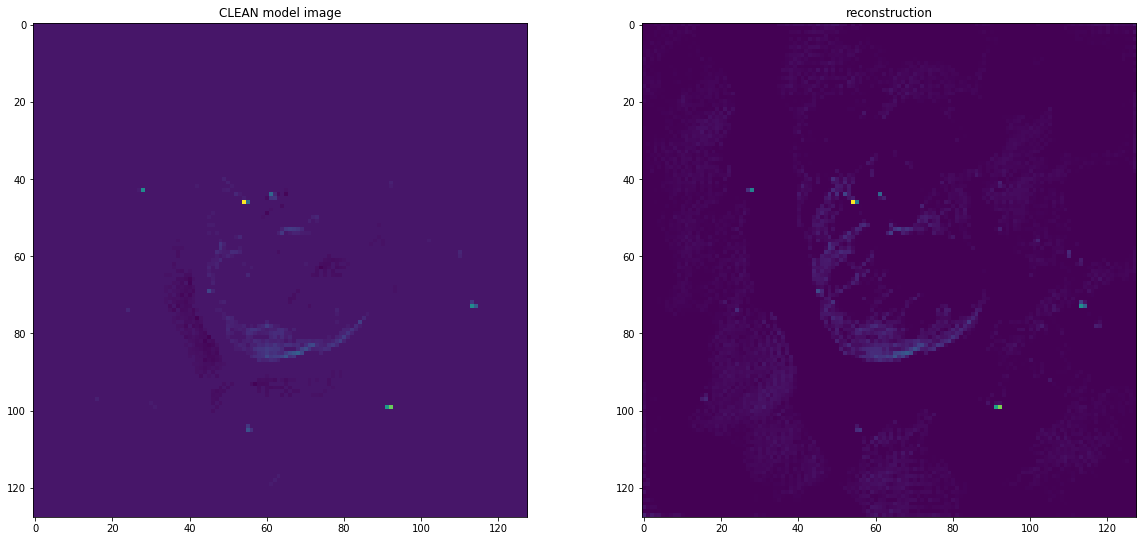

In [7]:
plot_comparison(model_map, 'CLEAN model image', results_dirty01, "reconstruction")

## Haar regularizer

$minimize \left \| D_b - x * PSF \right \|_2^2  + \lambda \left \| Hx \right \|_1 \; with\, x > 0$

In [14]:
dimensions = dirty_map.size
haar = np.zeros((dimensions,dimensions))
for j in range(0, dimensions):
    haar[0, j] = 1
    
p = 0
q = 1
p_val = 1
for k in range(1,dimensions):
    pixel = 2**(p/2)
    for j in range(0, dimensions):
        t = j/float(dimensions)
        if (q-1)/p_val <= t and t < (q-0.5)/p_val:
            haar[k, j] = pixel
        elif (q-0.5)/p_val <= t and t < q/p_val:
            haar[k, j] = -pixel
        else:
            haar[k, j] = 0
    q += 1
    if p_val == q-1:
        q = 1
        p += 1
        p_val = 1 << p
        
haar = 1.0/np.sqrt(dimensions) * haar

In [77]:
dimensions = dirty_map.size
haar2d = np.zeros((dimensions,dimensions))
norm = np.zeros(dimensions)
haar2d[0] = 1
norm[0] = dimensions

dim = np.zeros(dirty_map.shape)
def haar_insert(A,norm, x0,y0,x1,y1, k):
    xmid = int((x0+x1)/2)
    ymid = int((y0+y1)/2)

    dim[x0:xmid,y0:y1] = 1
    dim[xmid:x1,y0:y1] = -1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    dim[x0:xmid,ymid:y1] = -1
    dim[xmid:x1,ymid:y1] = 1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    dim[xmid:x1,y0:ymid] = 1
    dim[xmid:x1,ymid:y1] = -1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    
    dim[x0:x1, y0:y1] = 0
    if x1-x0 > 2 and y1-y0 >2:
        k = haar_insert(A, norm, x0,y0,xmid,ymid, k)
        k = haar_insert(A, norm, xmid,y0,x1,ymid, k)
        k = haar_insert(A, norm, x0,ymid,xmid,y1, k)
        k = haar_insert(A, norm, xmid,ymid,x1,y1, k)
    return k

k = 1
haar_insert(haar2d, norm, 0, 0 ,dim.shape[0], dim.shape[1], k)
haar2d =np.transpose(1/np.sqrt(norm) * np.transpose(haar2d))
#np.dot(np.transpose(haar2d), haar2d)

In [83]:
model = Model("haar regularizer")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar(lb=-GRB.INFINITY)
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

haar_var = model.addVars(dirty_map.size, lb=-GRB.INFINITY)     
haar_var_abs = model.addVars(dirty_map.size, lb=-GRB.INFINITY)
start_time = time.time()
for x in range(0, dirty_map.size):
    reg = LinExpr()
    reg.addTerms(haar2d[x], pixel_flat)
    model.addConstr(haar_var[x] == reg)
    model.addGenConstrAbs(haar_var_abs[x], haar_var[x])
elapsed_time = time.time() - start_time
print("done regularizer ", elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  62.9150390625 %
1.0
done psf modelling  20.52601933479309
done regularizer  25.804810047149658


In [84]:
lamb= 10
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    offset = x * dirty_map.shape[0]
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        objective += lamb * haar_var_abs[offset+y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_haar = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_haar[x,y]= pixelArr[x][y].x

Optimize a model with 8192 rows, 16384 columns and 6062162 nonzeros
Model has 4096 quadratic objective terms
Model has 4096 general constraints
Variable types: 16384 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+01, 1e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 3e+01]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve added 8192 rows and 0 columns
Presolve time: 9.38s
Presolved: 16384 rows, 16384 columns, 6078546 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 16384 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   4.097000e-03     11s
    3874    0.0000000e+00   0.000000e+00   2.230000e-04     16s
    4096    0.0000000e+00   0.000000e+00   0.000000e+00     17s
Extra 4096 simplex iterations after uncrush
 

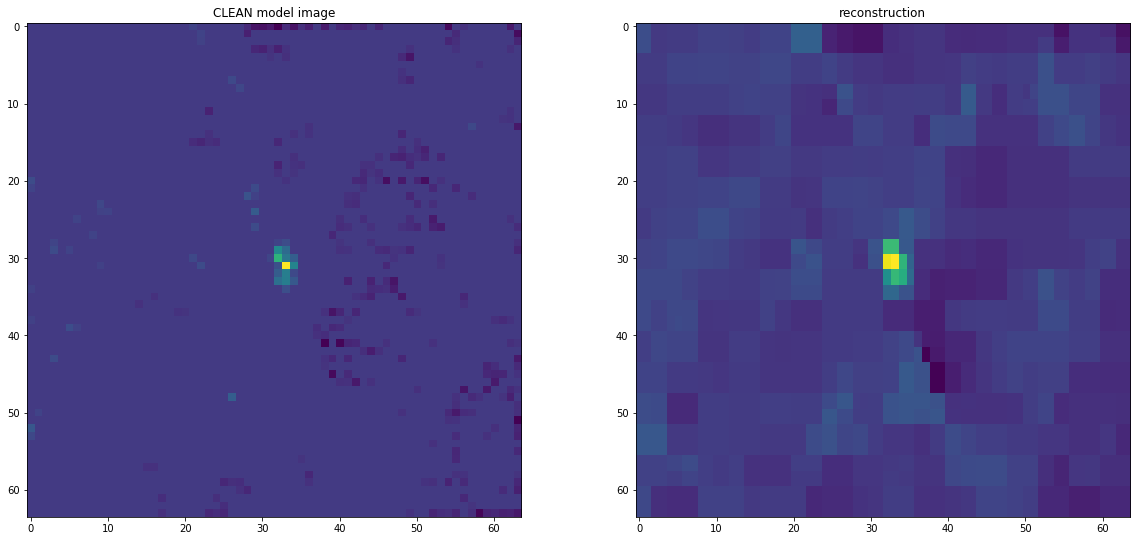

In [85]:
plot_comparison(model_map, 'CLEAN model image', results_haar, "reconstruction")

## Reconstruction with PSF in Fourier space with FIWT Regularization

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

(24+9j)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 32768 rows, 73728 columns and 48910 nonzeros
Model has 8192 quadratic objective terms
Model has 32768 general constraints
Variable types: 73728 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-10, 1e+00]
  Objective range  [2e-05, 7e+05]
  QObjective range [1e-04, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 3.770422e+08
Presolve removed 484 rows and 49394 columns
Presolve time: 0.74s
Presolved: 32284 rows, 24334 columns, 64568 nonzeros
Presolved model has 8192 quadratic objective terms
Variable types: 24334 continuous, 0 integer (0 binary)
   21938    2.4147228e+05   0.000000e+00   0.000000e+00      5s

Root relaxation: objective 2.414723e+05, 21938 iterations, 0.91 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb

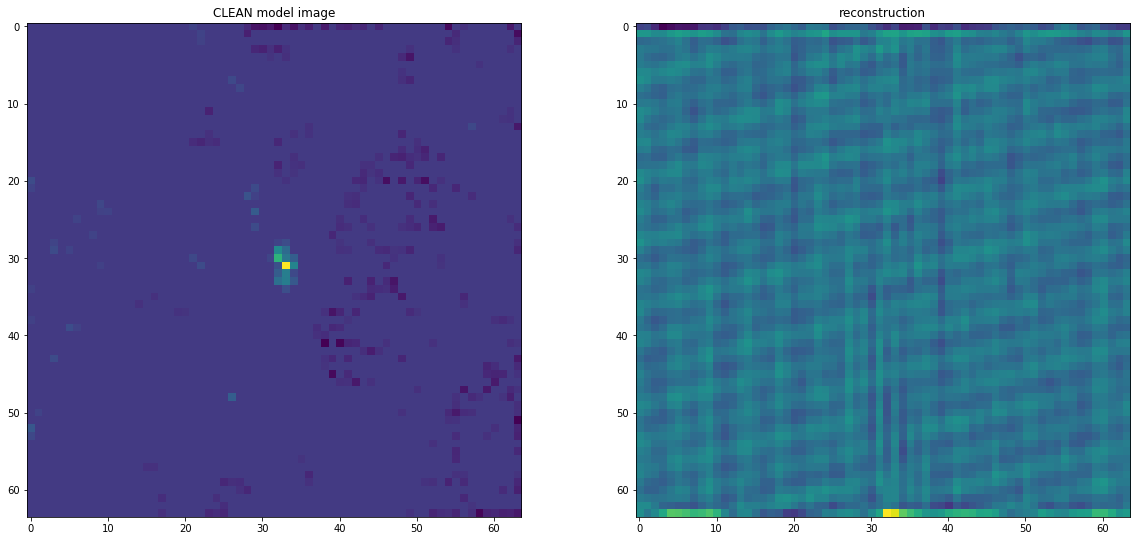

0.8530414274013641

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
3.9814016819000244
done


(135, 135)


In [156]:
print(math.floor(psf.shape[0]/2))
center =int(psf.shape[0]/2)
print(psf[center,center])

67
1.0


In [107]:
psf.shape[0]/2

68.5

In [ ]:
np.